In [10]:
import ada
from ada import data
import pandas as pd
import requests
from bs4 import BeautifulSoup
from re import sub
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import numpy as np
from datetime import datetime

import importlib
importlib.reload(ada.matching);

In [11]:
books_df = pd.read_json("merged_clean_Books.json",orient="records")
movies_df = pd.read_json("merged_clean_Movies.json",orient="records")

In [3]:
print(len(books_df['asin'].unique()))
print(len(movies_df['asin'].unique()))

2395
707


In [4]:
movies_users = movies_df['reviewerID'].unique()
books_users = books_df['reviewerID'].unique()
users_both = np.intersect1d(movies_users,books_users)
len(users_both)

4638

In [6]:
user_same_franchise = []
for user in users_both:
    movies_reviews_fr = movies_df[movies_df["reviewerID"]==user]["franchise_id"].unique()
    books_reviews_fr = books_df[books_df["reviewerID"]==user]["franchise_id"].unique()
    if len(np.intersect1d(movies_reviews_fr,books_reviews_fr))>0:
        user_same_franchise.append({"user":user,"franchises":np.intersect1d(movies_reviews_fr,books_reviews_fr)})

In [7]:
len(user_same_franchise)

1031

In [18]:
user_franchise_list = []
for user_dict in user_same_franchise:
    for fr in user_dict['franchises']:
        mov_mean = movies_df[(movies_df["reviewerID"]==user_dict['user']) & (movies_df["franchise_id"]==fr)]["overall"].mean()
        book_mean = books_df[(books_df["reviewerID"]==user_dict['user']) & (books_df["franchise_id"]==fr)]["overall"].mean()
        user_franchise_list.append([fr,book_mean,mov_mean])

In [19]:
user_franchise_df = pd.DataFrame(user_franchise_list,columns=["franchise_id","book_overall","movie_overall"])

In [21]:
user_franchise_df.describe()

,franchise_id,book_overall,movie_overall
count,1310.000000,1310.000000,1310.000000
mean,256.351908,4.476354,4.012875
std,129.500718,0.908610,1.224516
min,0.000000,1.000000,1.000000
25%,139.000000,4.000000,3.000000
50%,287.000000,5.000000,4.500000
75%,363.000000,5.000000,5.000000
max,506.000000,5.000000,5.000000


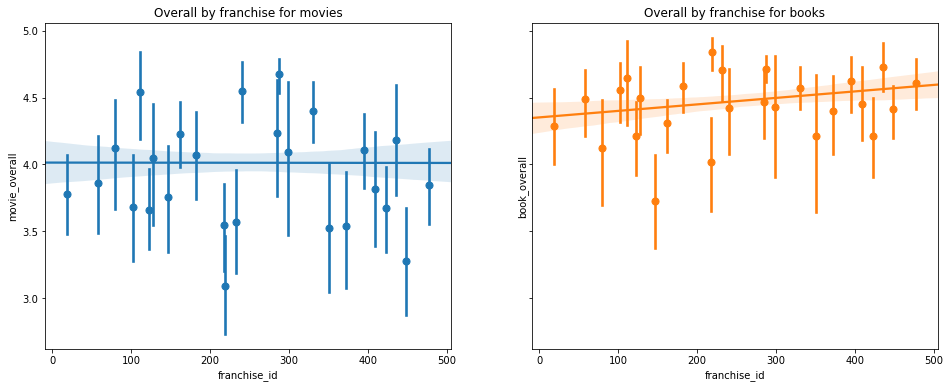

In [34]:
zone, (plot1, plot2) = plt.subplots(ncols=2,sharey=True)
zone.set_size_inches(16, 6)

plot1 = sb.regplot(y = "movie_overall",x="franchise_id", data=user_franchise_df, ax = plot1,x_bins=30)
plot1.set_title("Overall by franchise for movies")

plot1 = sb.regplot(y = "book_overall",x="franchise_id", data=user_franchise_df, ax = plot2,x_bins=30)
plot2.set_title("Overall by franchise for books")

In [32]:
user_franchise_df[user_franchise_df["movie_overall"]>user_franchise_df["book_overall"]]["franchise_id"].count()/user_franchise_df.shape[0]

0.15190839694656488

We can clearly see that grades are better for books than for movies, but the most important aspect is that 85% of the time a user give a better grade for a book (or the mean of books) than for the associated movie (or mean for all movies)

In [12]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
    
movies_df['sentiment'] = movies_df['reviewText'].apply(lambda x: analyser.polarity_scores(x))

In [35]:
def divise_sentiment(x):
    return pd.Series([x['neg'],
                    x['neu'],
                    x['pos'],
                     x['compound']])

movies_df[['neg', 'neu', 'pos','compound']] = movies_df['sentiment'].apply(divise_sentiment)

In [37]:
books_df['sentiment'] = books_df['reviewText'].apply(lambda x: analyser.polarity_scores(x))
books_df[['neg', 'neu', 'pos','compound']] = books_df['sentiment'].apply(divise_sentiment)

In [47]:
#A ne pas copier
def plotCor(df1,df2,y,x,title):
    zone, (plot1, plot2) = plt.subplots(ncols=2,sharey=True)
    zone.set_size_inches(16, 6)

    plot1 = sb.regplot(y =y,x=x, data=df1, ax = plot1,x_bins=10)
    plot1.set_title(title +" for movies")

    plot2 = sb.regplot(y =y ,x= x, data=df2, ax = plot2,x_bins=10)
    plot2.set_title(title + " for books")

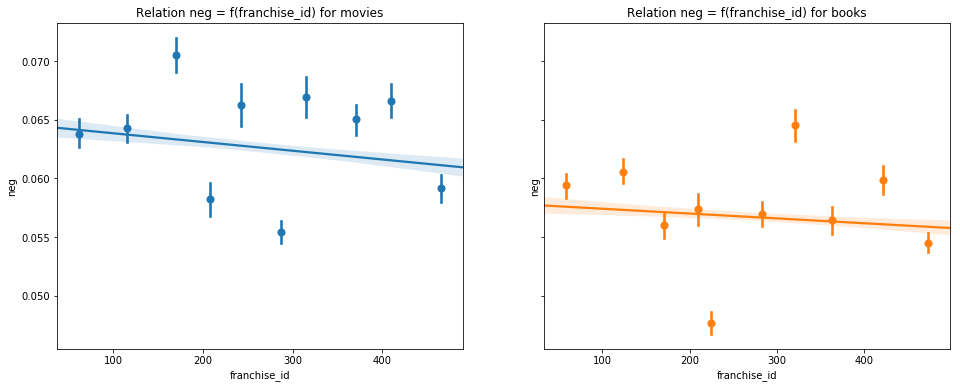

In [48]:
plotCor(movies_df,books_df,"neg","franchise_id","Relation neg = f(franchise_id)")

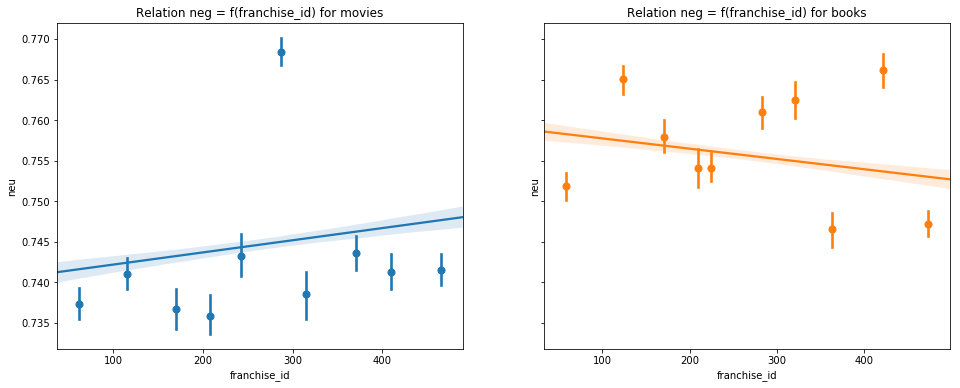

In [49]:
plotCor(movies_df,books_df,"neu","franchise_id","Relation neg = f(franchise_id)")

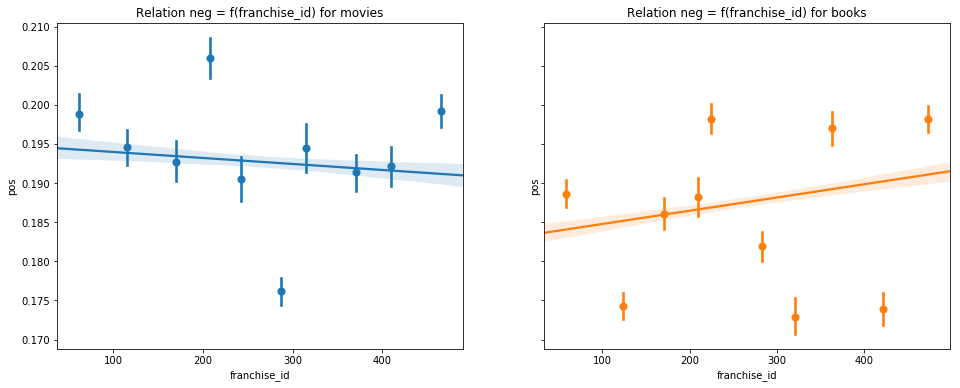

In [50]:
plotCor(movies_df,books_df,"pos","franchise_id","Relation neg = f(franchise_id)")

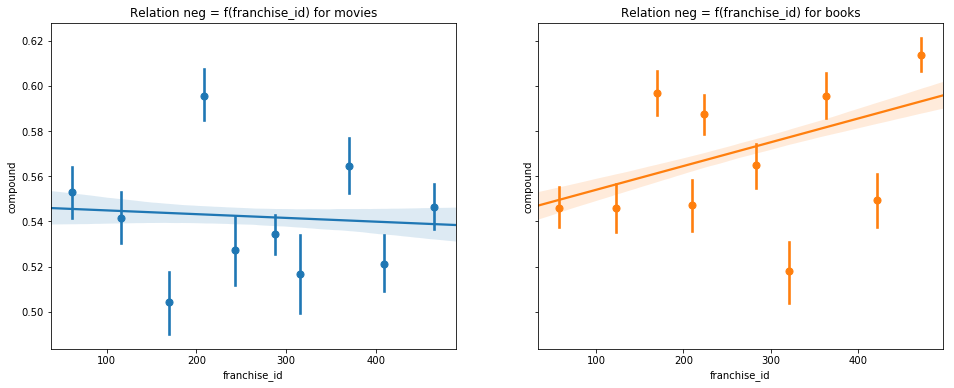

In [51]:
plotCor(movies_df,books_df,"compound","franchise_id","Relation neg = f(franchise_id)")

From the documentation : 
```


    The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

    It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:

        positive sentiment: compound score >= 0.5
        neutral sentiment: (compound score > -0.5) and (compound score < 0.5)
        negative sentiment: compound score <= -0.5

    The pos, neu, and neg scores are ratios for proportions of text that fall in each category (so these should all add up to be 1... or close to it with float operation). These are the most useful metrics if you want multidimensional measures of sentiment for a given sentence.

```

TODO change graph ? 
TODO analysis

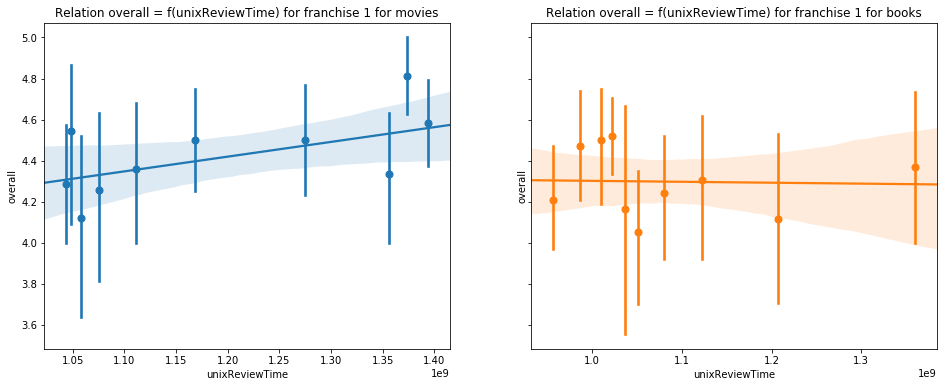

In [52]:
plotCor(movies_df[movies_df['franchise_id']==1],books_df[books_df["franchise_id"]==1],"overall","unixReviewTime","Relation overall = f(unixReviewTime) for franchise 1")

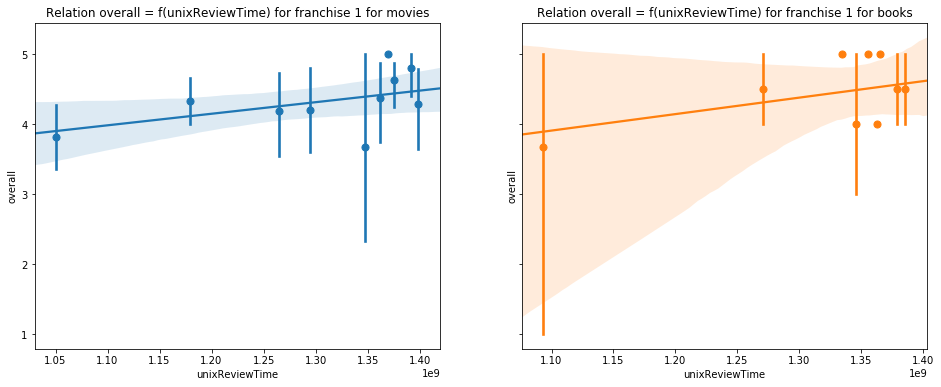

In [53]:
plotCor(movies_df[movies_df['franchise_id']==10],books_df[books_df["franchise_id"]==10],"overall","unixReviewTime","Relation overall = f(unixReviewTime) for franchise 1")

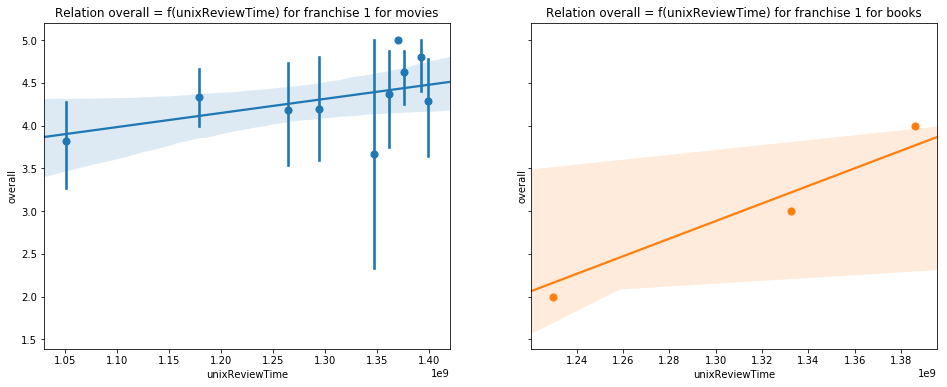

In [54]:
plotCor(movies_df[movies_df['franchise_id']==10],books_df[books_df["franchise_id"]==100],"overall","unixReviewTime","Relation overall = f(unixReviewTime) for franchise 1")

We can notice than for some franchises there is a clear evolution during the time, evolution which is different for books and movies. We should take this parameter into account for our next milestone